In [1]:
import pytesseract as pt
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pdf2image import convert_from_path

In [2]:
def area(approx):
    x = approx[:,0,0]
    y = approx[:,0,1]
    return (max(x)-min(x))*(max(y)-min(y))

def start_point(approx):
    x = approx[:,0,0]
    y = approx[:,0,1]
    return (min(x),max(y))

def end_point(approx):
    x = approx[:,0,0]
    y = approx[:,0,1]
    return (max(x),min(y))

def get_points(approx):
    x = approx[:,0,0]
    y = approx[:,0,1]
    return (min(x),max(x),min(y),max(y))

def get_all_points(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coordinates = []
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            if (area(approx)>5000):
                coordinates.append(get_points(approx))
#                 print(area(approx))
#                 cv2.rectangle(image, start_point(approx),end_point(approx), (0, 255, 255), 5)
    return coordinates

def get_tables(image):
    coordinates = get_all_points(image)
#     print(len(coordinates))
    tables = []
    for coordinate in coordinates:
        tables.append(image[coordinate[2]:coordinate[3],coordinate[0]:coordinate[1]])
    return tables

def get_image_with_table(img):
    image = img
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coordinates = []
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            if (area(approx)>5000):
                coordinates.append(get_points(approx))
#                 print(area(approx))
                cv2.rectangle(image, start_point(approx),end_point(approx), (0, 255, 255), 5)
    return image

In [30]:
def get_cells_coordinates(image,v_erode,v_dilate,h_erode,h_dilate):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh1,img = cv2.threshold(img,128,255,cv2.THRESH_OTSU)
    img = cv2.bitwise_not(img)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, img.shape[1]//150))
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//150, 1))

    vertical_lines = cv2.erode(img, vertical_kernel, iterations=v_erode)
    vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=v_dilate)

    horizontal_lines = cv2.erode(img, hor_kernel, iterations=h_erode)
    horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=h_dilate)

    vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)

    thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255,cv2.THRESH_OTSU)
    b_image = cv2.bitwise_not(cv2.bitwise_xor(img,vertical_horizontal_lines))
    
#     plt.imshow(vertical_horizontal_lines)
#     plt.show()

    contours, hierarchy = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    temp_bound_box = [cv2.boundingRect(c) for c in contours]
    (contours, temp_bound_box) = zip(*sorted(zip(contours, temp_bound_box),key=lambda x:x[1][1]))
    boundingBoxes=[]
    for box in temp_bound_box:
#         print(box)
        boundingBoxes.append(box)
    return vertical_horizontal_lines

def get_text_csv(bounding_boxes,image):
#     print(bounding_boxes)
    cols = len(np.unique(np.array(bounding_boxes)[:,0]))
    rows = len(np.unique(np.array(bounding_boxes)[:,1]))
    
    rows_start_points = sorted(np.unique(np.array(bounding_boxes)[:,1]))
    cols_start_points = sorted(np.unique(np.array(bounding_boxes)[:,0]))
    rows_end_points = sorted(np.unique(np.array(bounding_boxes)[:,1]+np.array(bounding_boxes)[:,3]))
    cols_end_points = sorted(np.unique(np.array(bounding_boxes)[:,0]+np.array(bounding_boxes)[:,2]))
    
    table = []
    for i in range(rows):
        table.append([])
        for j in range(cols):
            table[i].append(())

    for idx,box in enumerate(bounding_boxes):
        col_start, row_start, w, h = box
        row_end, col_end = row_start+h,col_start+w
        #     print(rows_start_points.index(row_start)-rows_end_points.index(row_end))
        for i in range(rows_start_points.index(row_start),rows_end_points.index(row_end)+1):
            for j in range(cols_start_points.index(col_start),cols_end_points.index(col_end)+1):
                table[i][j]=box
#                 print(i,j,idx)
#     display_cell(image,table[7][0])
    # text = []
    all_text = ''
    for idx,row in enumerate(table):
    #     text.append([])
        for cell in row:
#             print(cell)
            x, y, w, h = cell
            cell_image=image[y:y+h,x:x+w]
            kernel = np.ones((3,3),np.uint8)
            cell_image = cv2.erode(cell_image, kernel, iterations = 1)
            # cell_image = cv2.cvtColor(cell_image, cv2.COLOR_BGR2GRAY) 
            cell_image = cv2.resize(cell_image,(np.shape(cell_image)[1]*2,np.shape(cell_image)[0]*2),cv2.INTER_LINEAR)
            # cell_image = cv2.threshold(cell_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # print(pt.image_to_string(cell_image,config='--psm 6',lang='pan'),np.shape(cell_image))
            ocr_text = pt.image_to_string(cell_image,config='--psm 6',
                                          lang='pan').replace('\n','').replace('\x0c','').replace('_','')
#             print(ocr_text)
            all_text = all_text+ocr_text+','
        #         text[idx].append(ocr_text)
        all_text=all_text+'\n'
    return all_text

In [4]:
def get_cells_coordinates_include_verification(image,v_erode,v_dilate,h_erode,h_dilate):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh1,img = cv2.threshold(img,128,255,cv2.THRESH_OTSU)
    img = cv2.bitwise_not(img)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, img.shape[1]//150))
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//150, 1))

    vertical_lines = cv2.erode(img, vertical_kernel, iterations=v_erode)
    vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=v_dilate)

    horizontal_lines = cv2.erode(img, hor_kernel, iterations=h_erode)
    horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=h_dilate)

    vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)

    thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255,cv2.THRESH_OTSU)
    b_image = cv2.bitwise_not(cv2.bitwise_xor(img,vertical_horizontal_lines))

    contours, hierarchy = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    temp_bound_box = [cv2.boundingRect(c) for c in contours]
    (contours, temp_bound_box) = zip(*sorted(zip(contours, temp_bound_box),key=lambda x:x[1][1]))
    boundingBoxes=[]
    for box in temp_bound_box:
#         print(box)
        boundingBoxes.append(box)
    print(boundingBoxes[0][2:],(np.shape(image)[1],np.shape(image)[0]))
    if (boundingBoxes[0][2]==np.shape(image)[1] and np.shape(image)[0]==boundingBoxes[0][3]):
        print('same')
        return boundingBoxes[1:]
    if (np.shape(image)[1]-boundingBoxes[0][2]>200 or
              np.shape(image)[0]-boundingBoxes[0][3]>200):
        return boundingBoxes
    x = input()
    if (x=='n'):
        return boundingBoxes
    return boundingBoxes[1:]

In [5]:
# 6,20,35,50
def get_text_csv2(bounding_boxes,image):
#     print(bounding_boxes)
    cols = len(np.unique(np.array(bounding_boxes)[:,0]))
    rows = len(np.unique(np.array(bounding_boxes)[:,1]))
    
    rows_start_points = sorted(np.unique(np.array(bounding_boxes)[:,1]))
    cols_start_points = sorted(np.unique(np.array(bounding_boxes)[:,0]))
    rows_end_points = sorted(np.unique(np.array(bounding_boxes)[:,1]+np.array(bounding_boxes)[:,3]))
    cols_end_points = sorted(np.unique(np.array(bounding_boxes)[:,0]+np.array(bounding_boxes)[:,2]))
    
    table = []
    for i in range(rows):
        table.append([])
        for j in range(cols):
            table[i].append(())

    for idx,box in enumerate(bounding_boxes):
        col_start, row_start, w, h = box
        row_end, col_end = row_start+h,col_start+w
        #     print(rows_start_points.index(row_start)-rows_end_points.index(row_end))
        for i in range(rows_start_points.index(row_start),rows_end_points.index(row_end)+1):
            for j in range(cols_start_points.index(col_start),cols_end_points.index(col_end)+1):
                table[i][j]=box
#                 print(i,j,idx)
#     display_cell(image,table[7][0])
    # text = []
    all_text = ''
    for idx,row in enumerate(table):
    #     text.append([])
        for cell in row:
#             print(cell)
            x, y, w, h = cell
            cell_image=image[y:y+h,x:x+w]
            # kernel = np.ones((3,3),np.uint8)
            # cell_image = cv2.erode(cell_image, kernel, iterations = 1)
            # cell_image = cv2.cvtColor(cell_image, cv2.COLOR_BGR2GRAY) 
            # cell_image = cv2.resize(cell_image,(np.shape(cell_image)[1]*2,np.shape(cell_image)[0]*2),cv2.INTER_LINEAR)
            # cell_image = cv2.threshold(cell_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # print(pt.image_to_string(cell_image,config='--psm 6',lang='pan'),np.shape(cell_image))
            ocr_text = pt.image_to_string(cell_image,config='--psm 6',
                                          lang='pan').replace('\n','').replace('\x0c','').replace('_','')
#             print(ocr_text)
            all_text = all_text+ocr_text+','
        #         text[idx].append(ocr_text)
        all_text=all_text+'\n'
    return all_text

In [6]:
# 6,25,35,50

In [33]:
book = 'data_books/punjabi/pp_veg_pbi_table.pdf'
# book = '/home/aakash/Downloads/pp_veg_pbi_table.pdf'
images = convert_from_path(book,dpi=300)
tables = [get_tables(np.array(image)) for image in images]

In [34]:
# tables=[tables[1],tables[2],tables[3],tables[7],tables[11]]
defected_pages=[15,16,17,24,28,36,48,53,55,61]

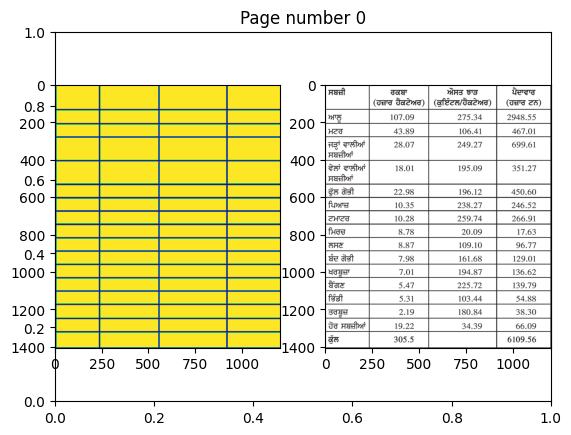

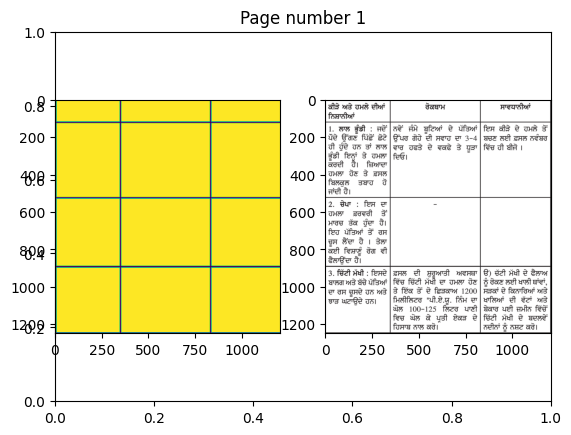

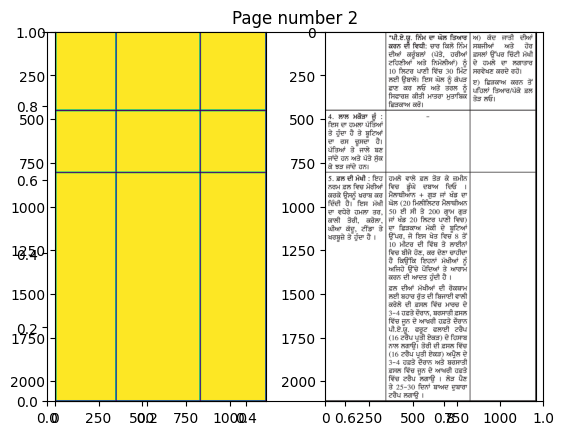

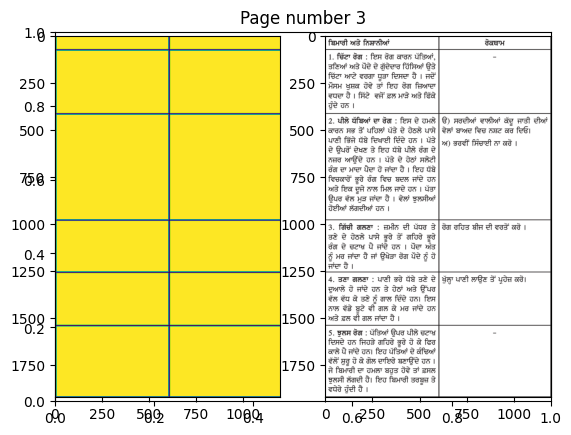

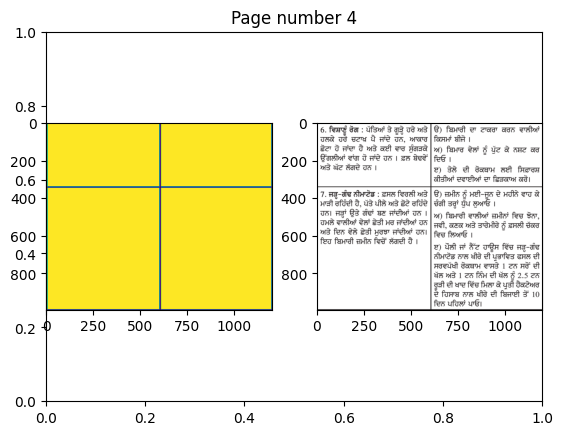

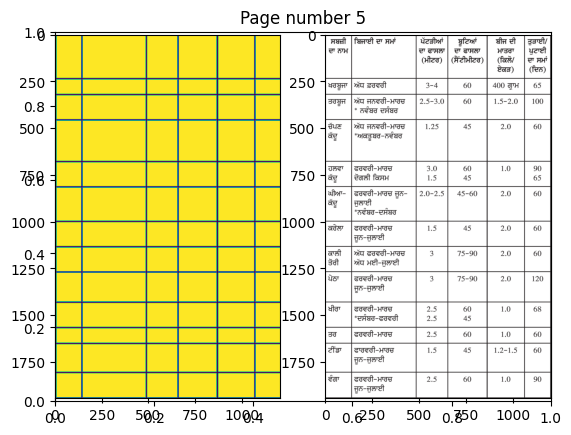

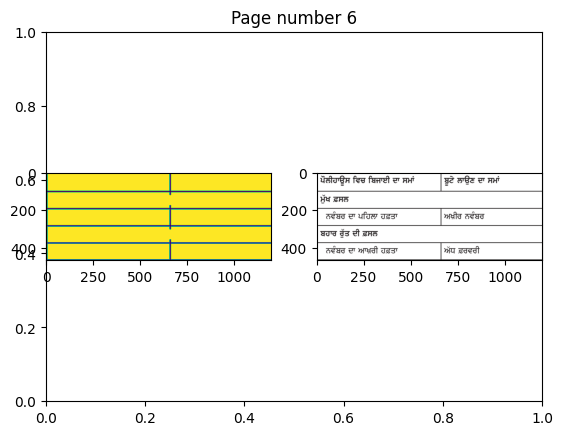

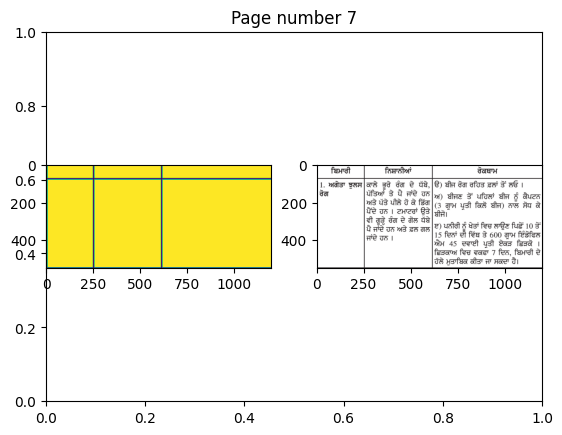

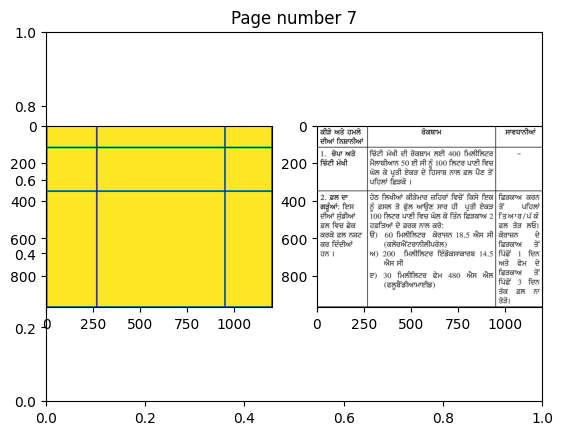

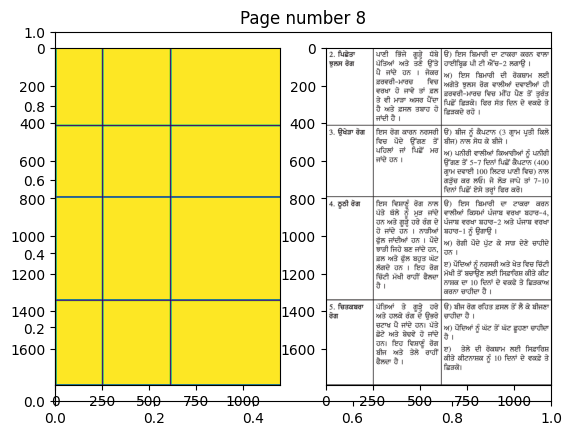

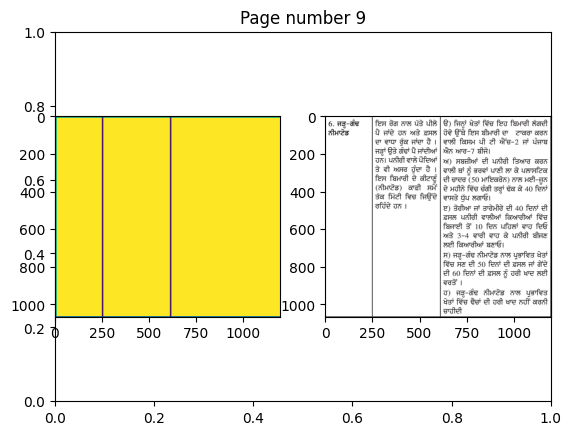

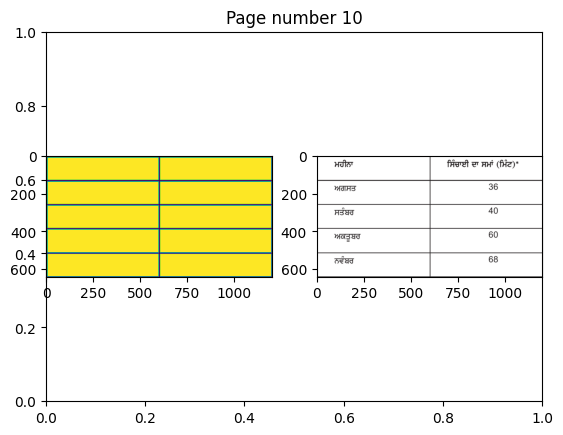

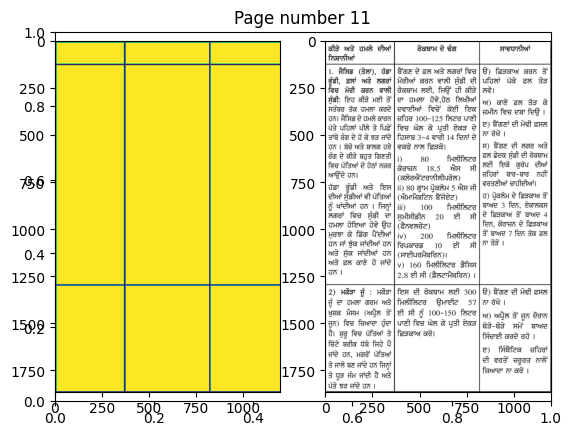

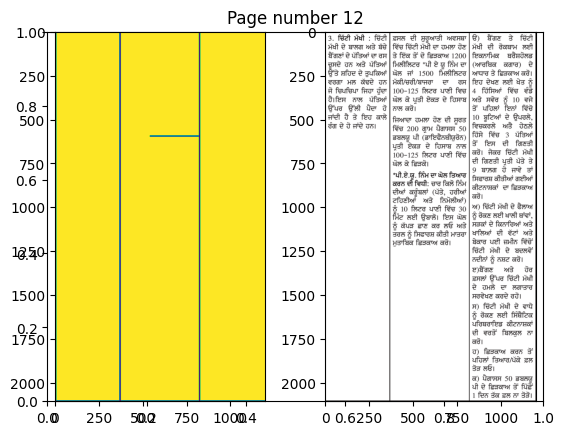

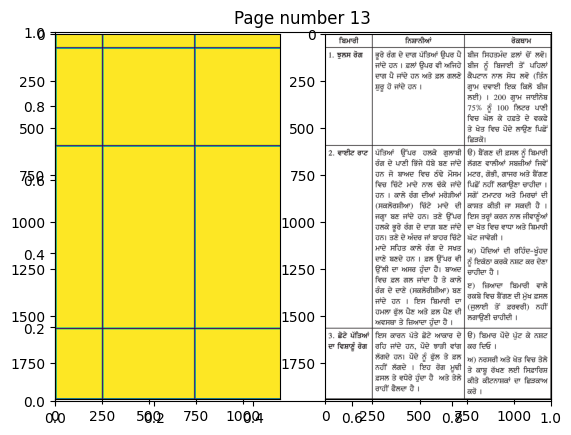

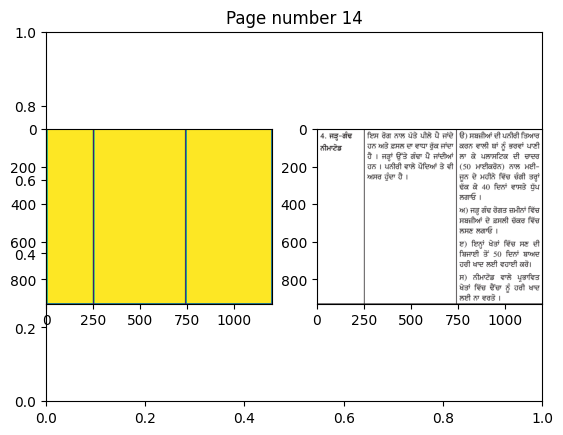

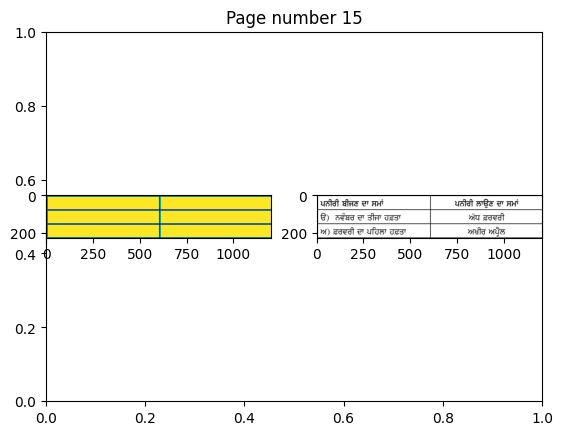

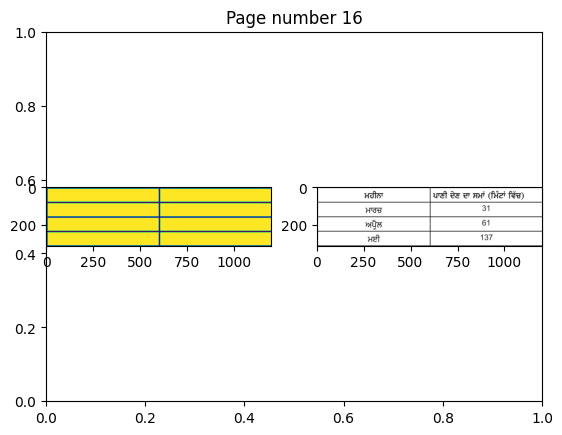

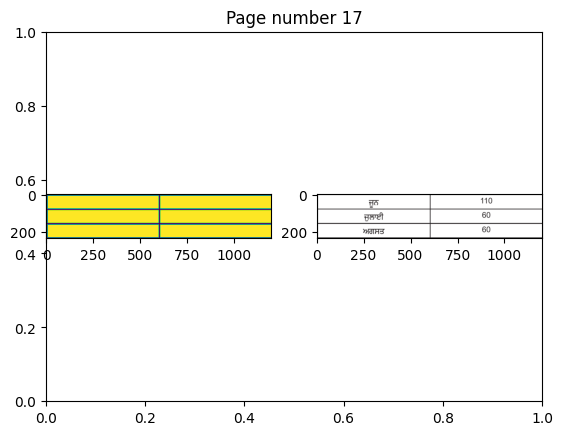

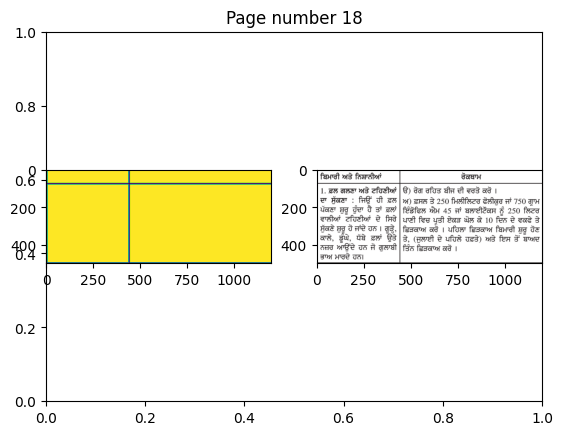

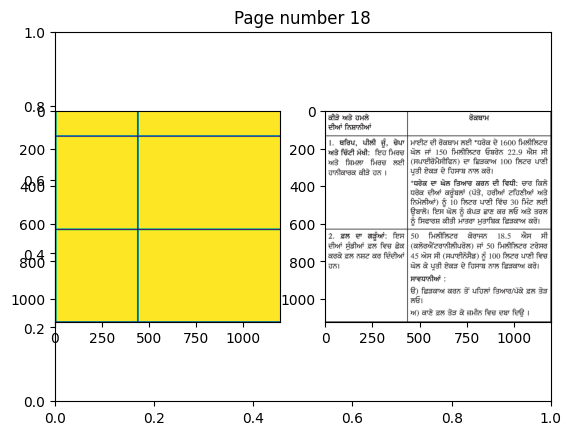

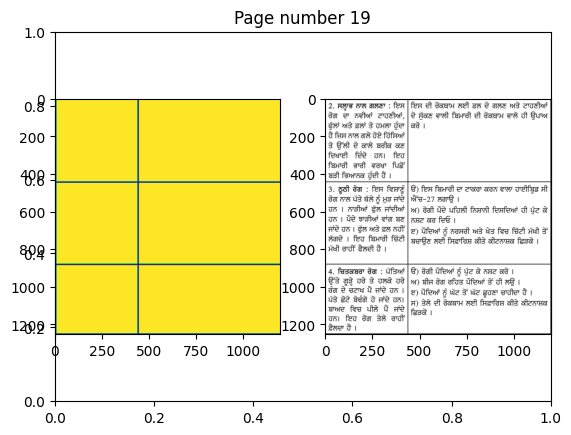

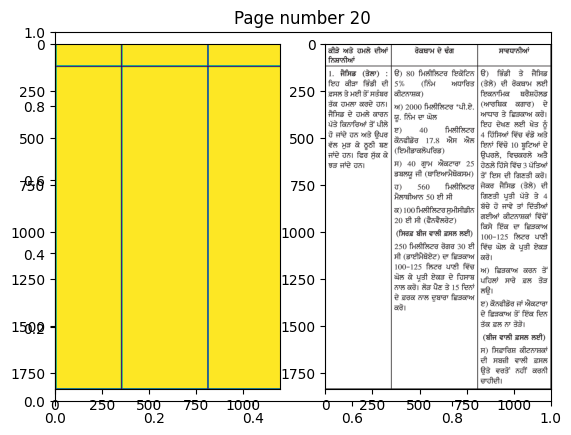

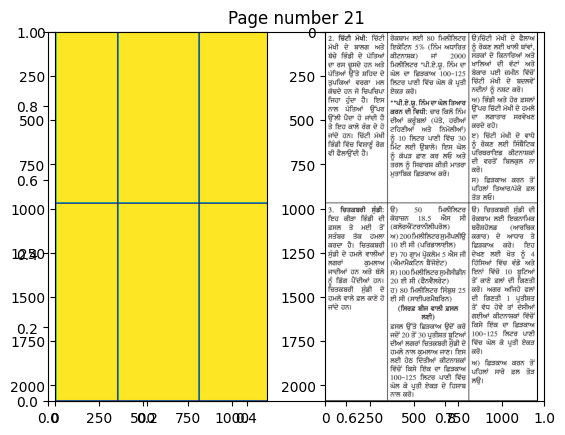

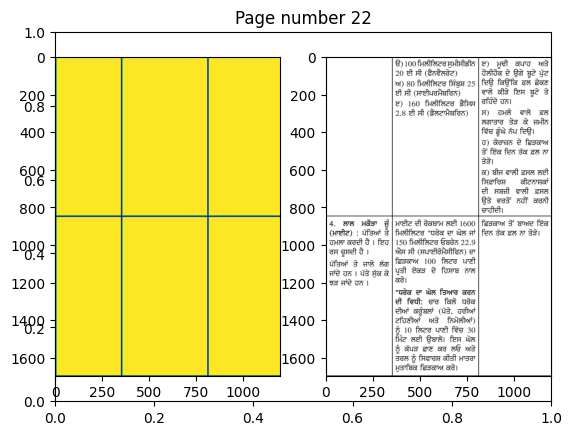

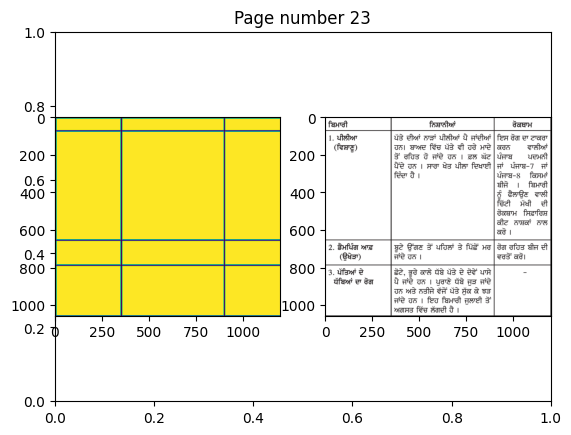

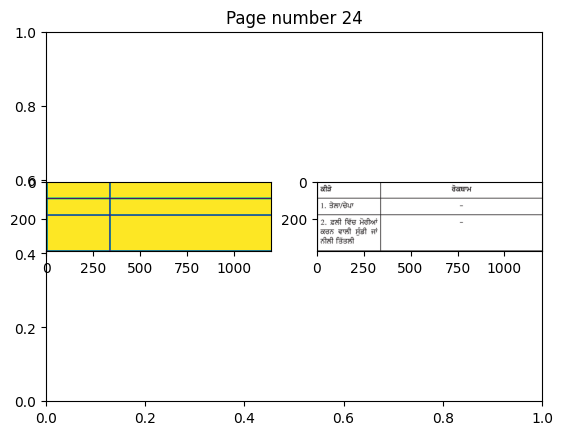

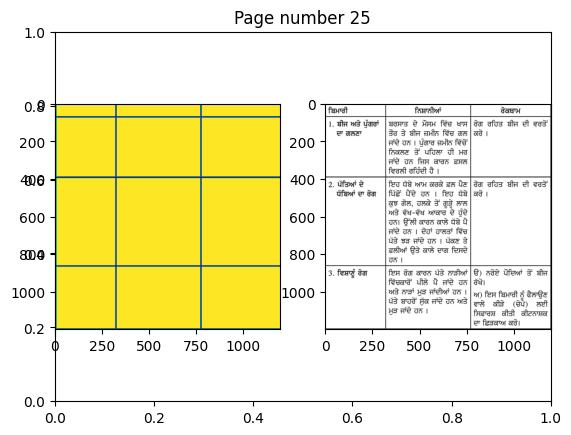

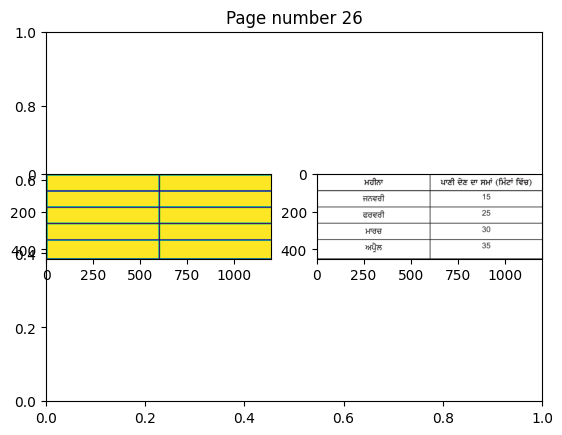

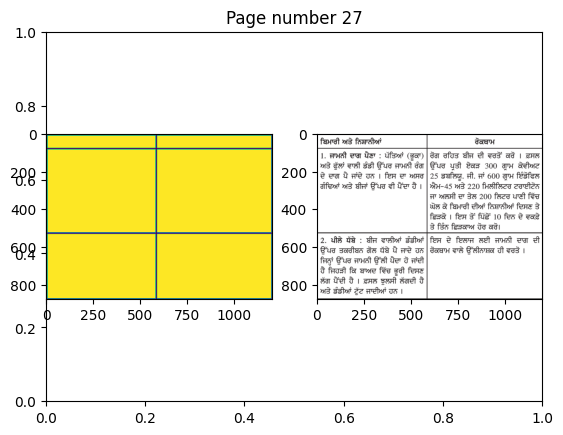

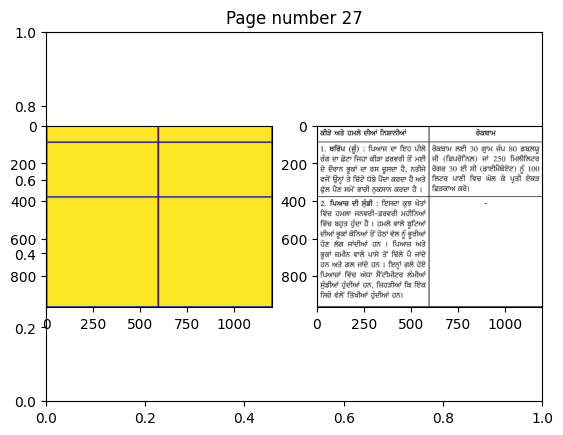

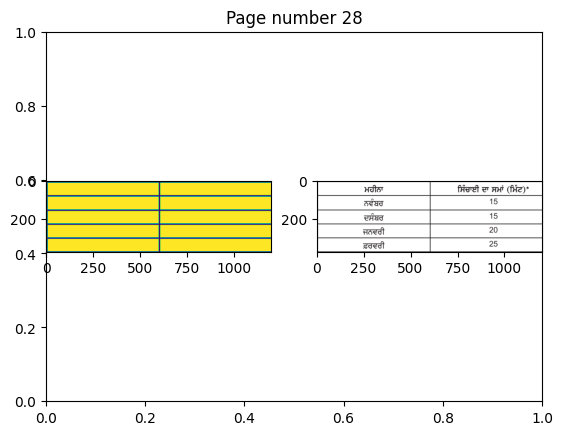

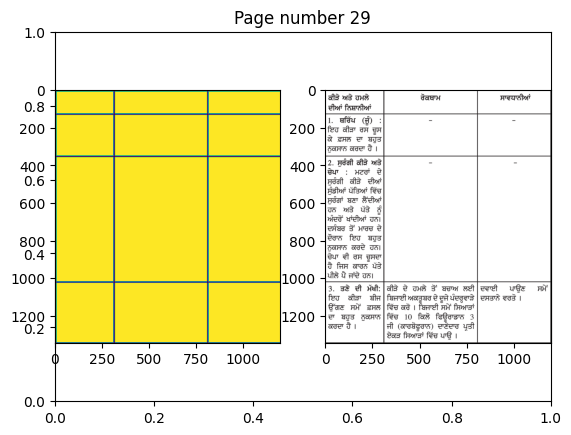

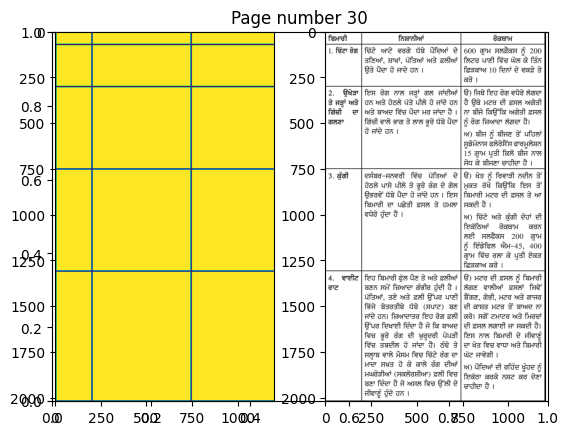

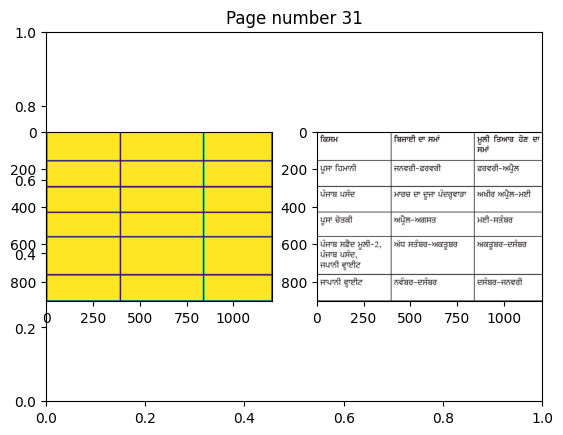

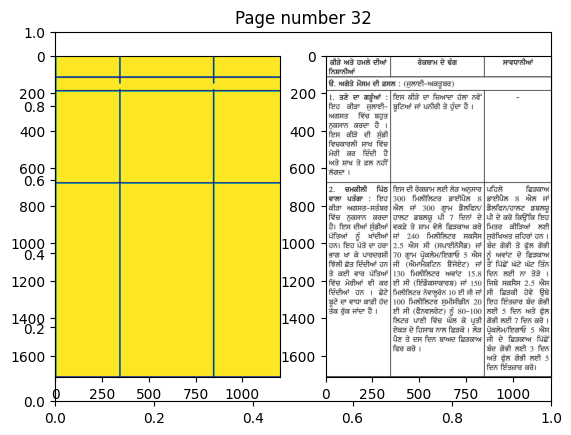

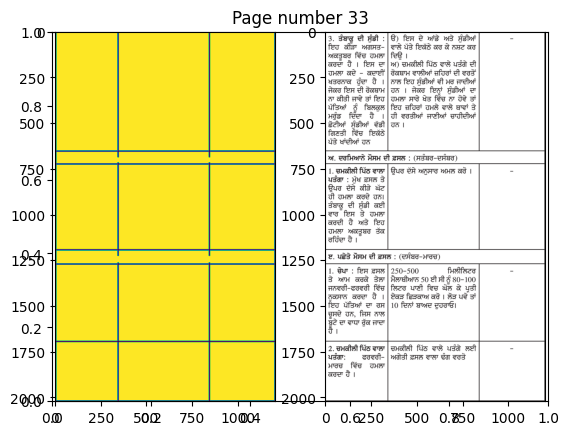

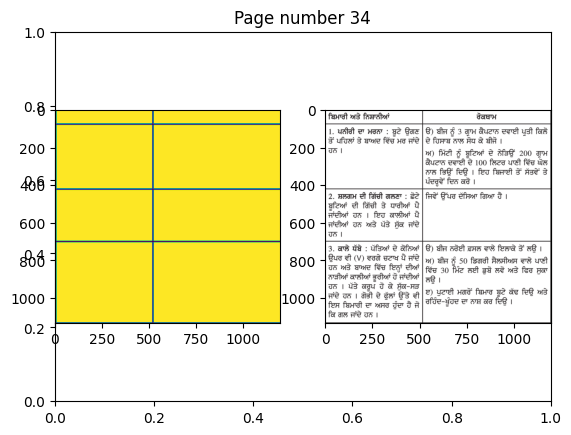

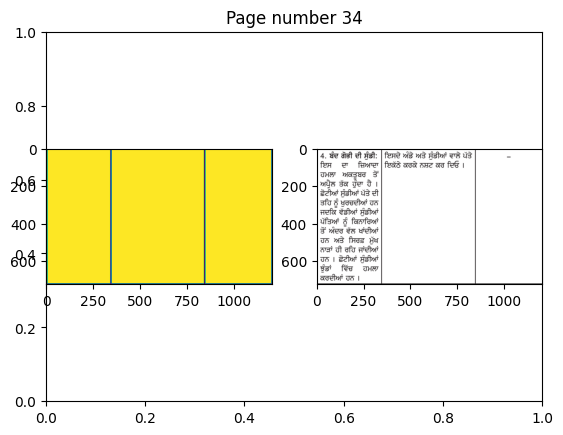

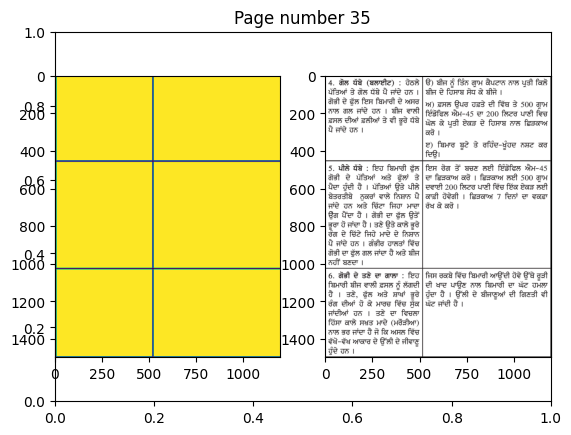

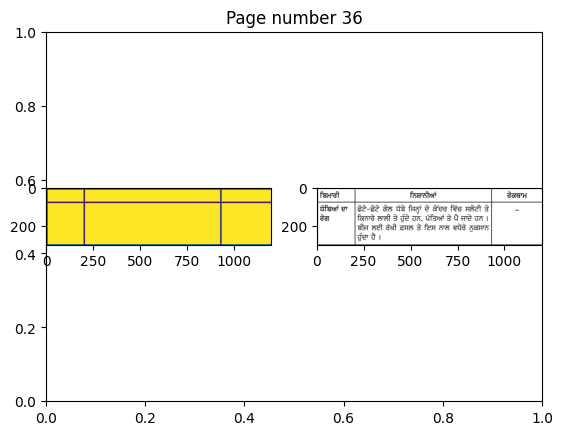

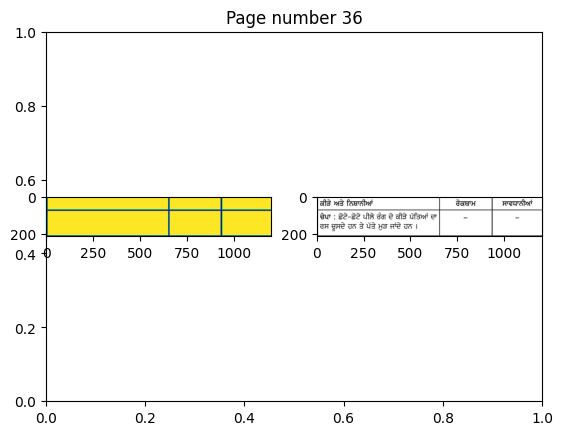

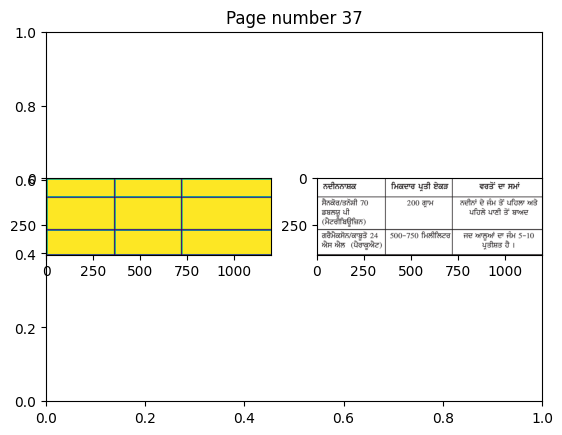

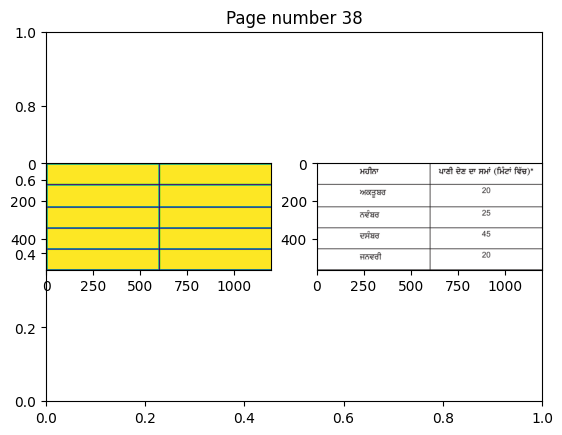

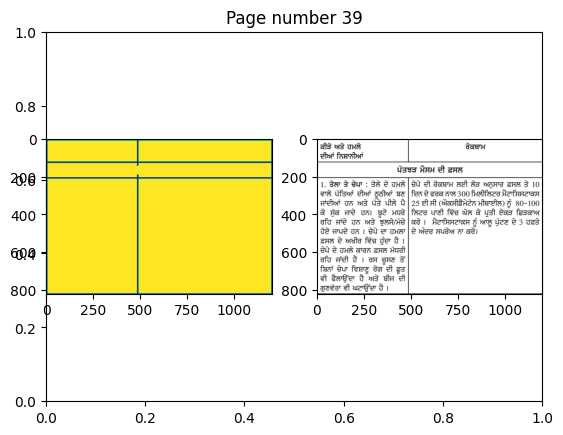

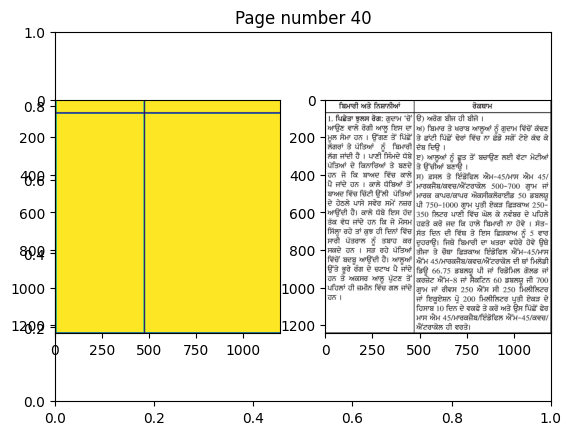

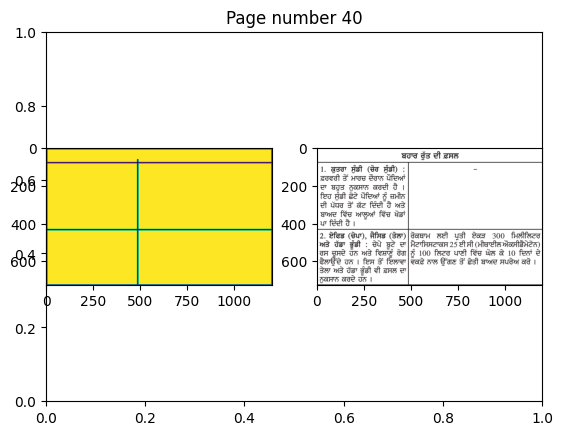

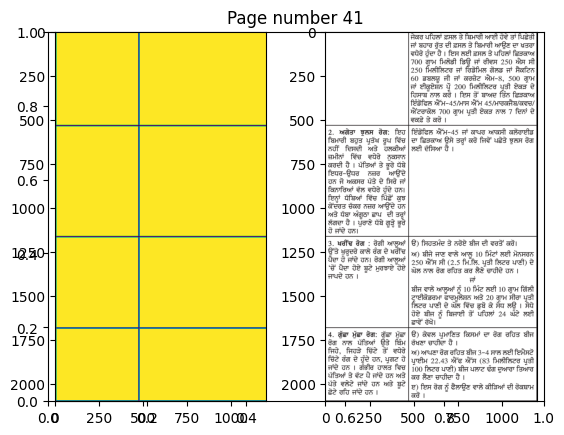

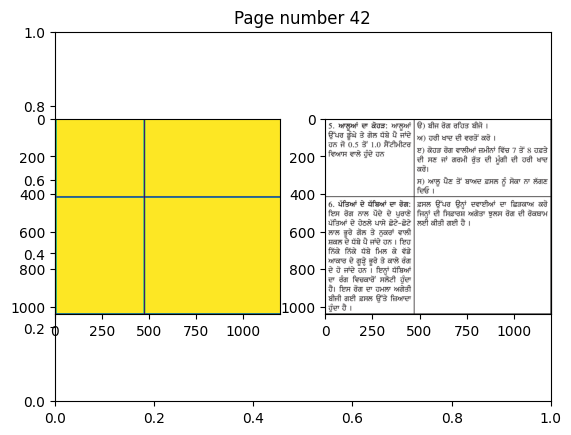

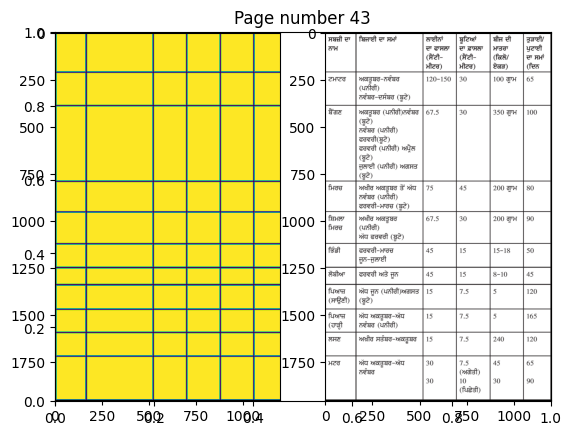

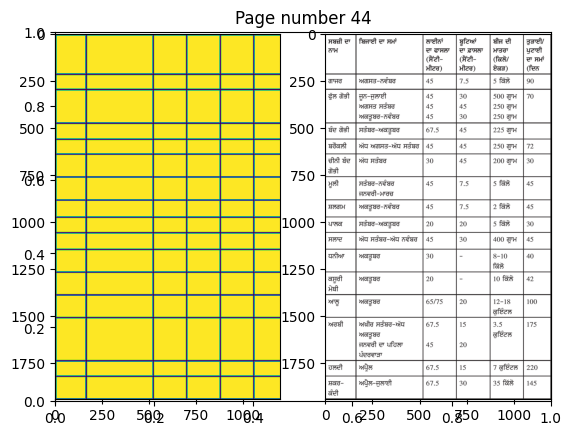

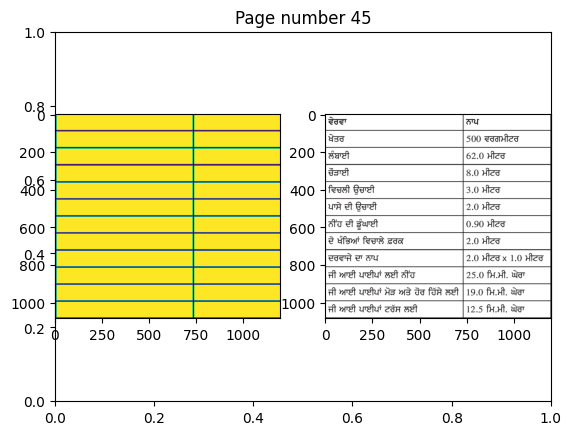

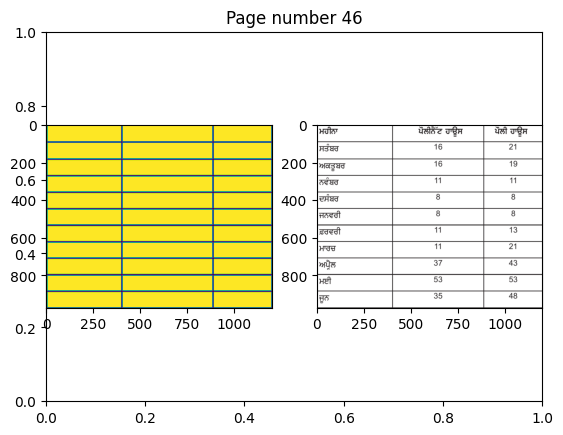

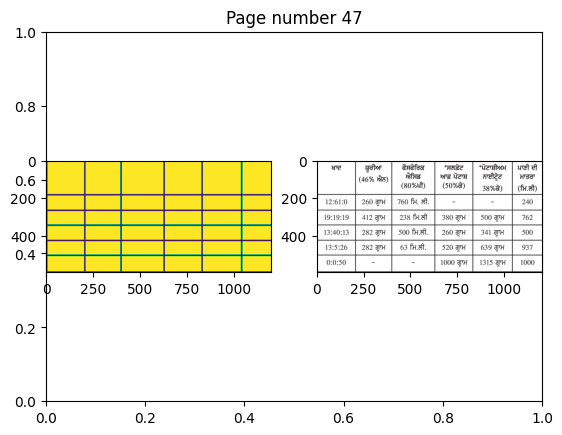

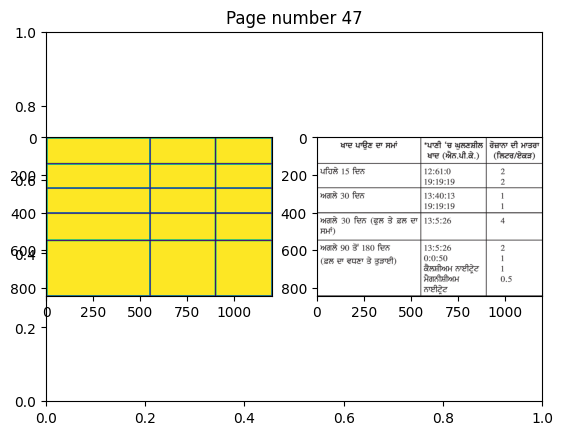

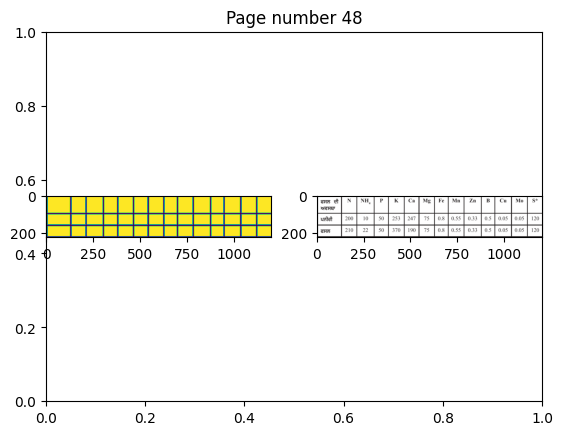

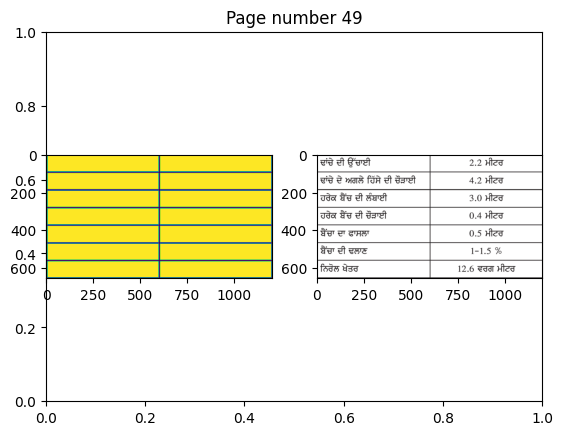

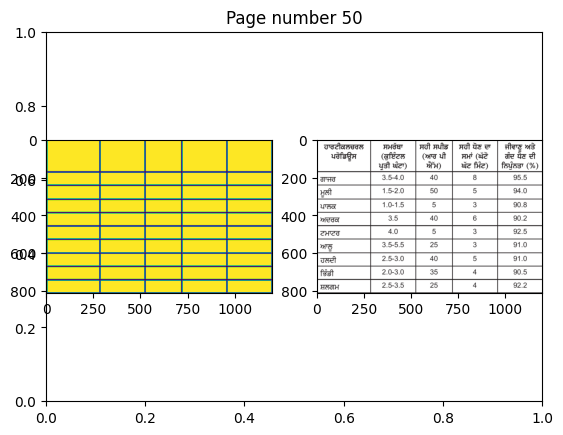

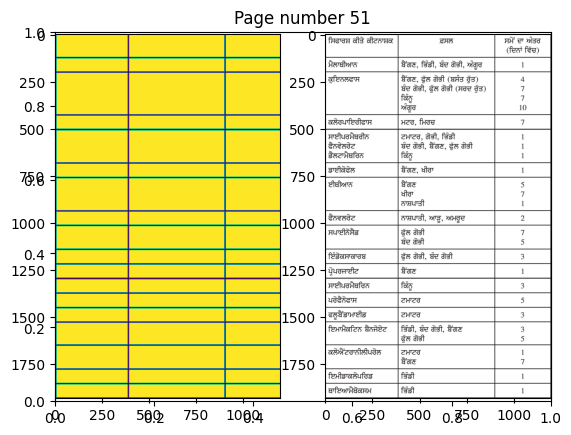

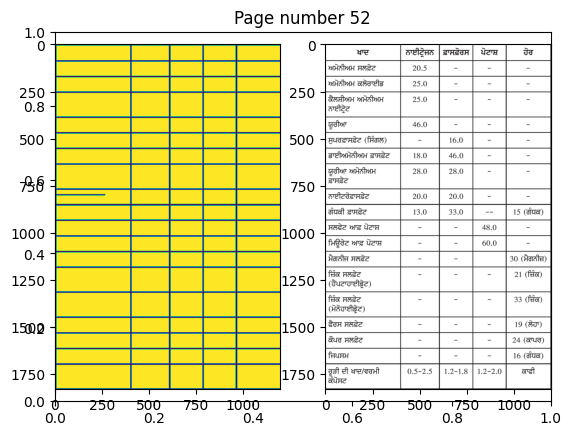

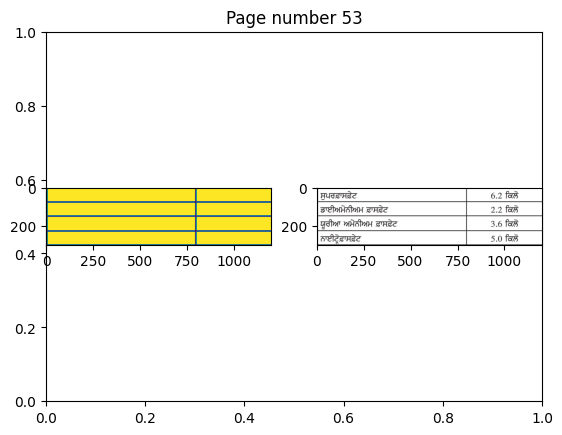

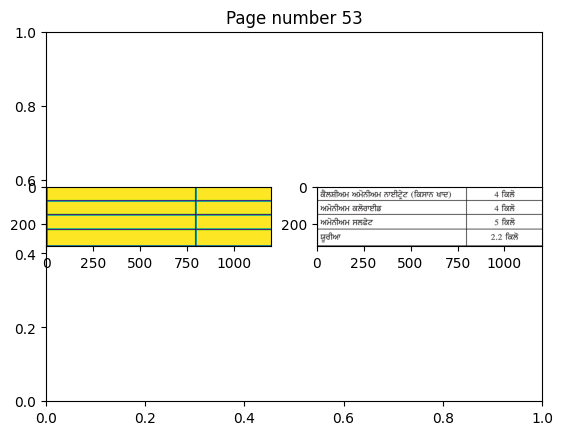

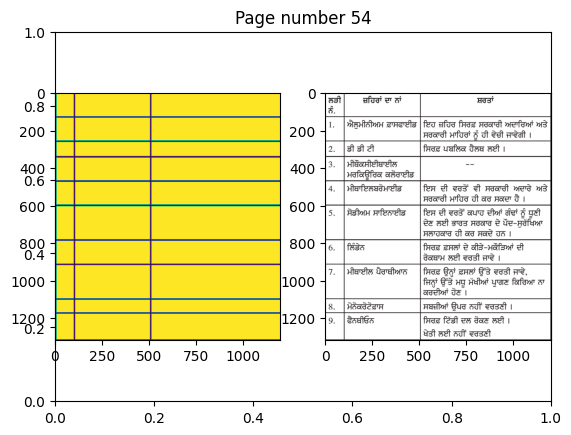

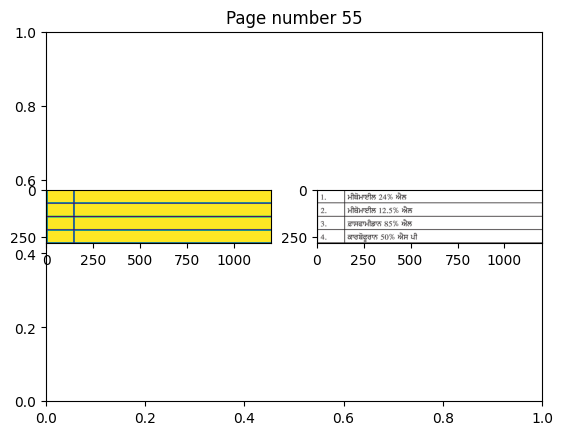

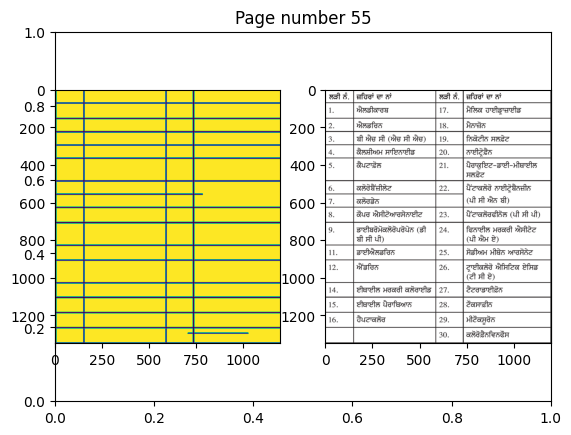

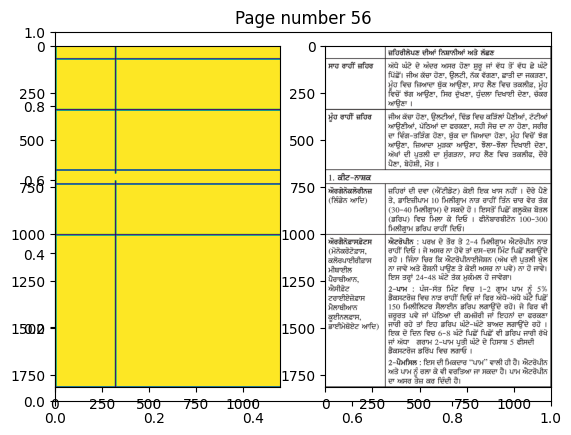

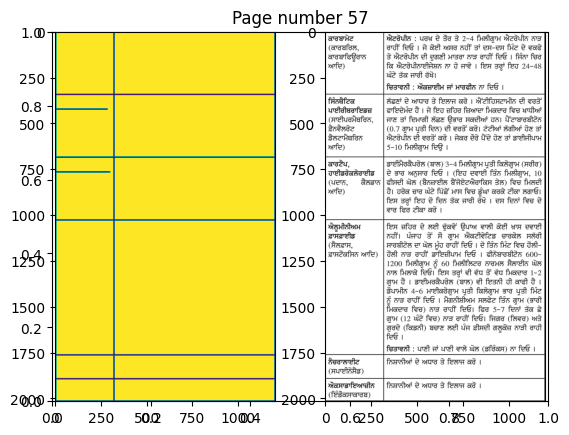

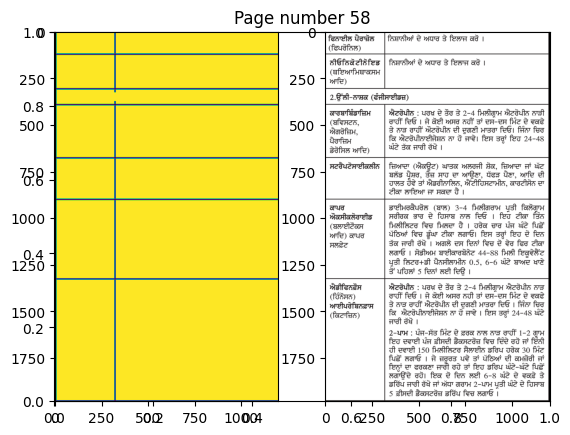

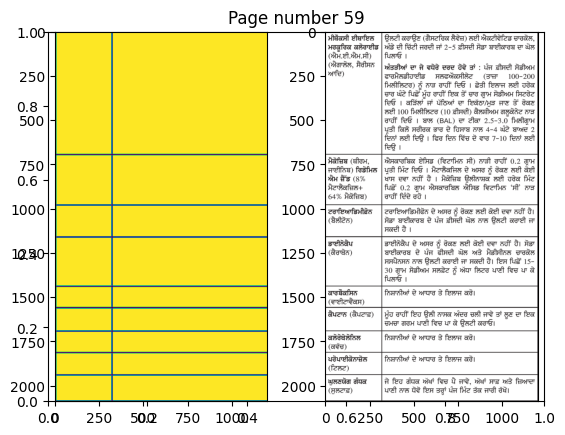

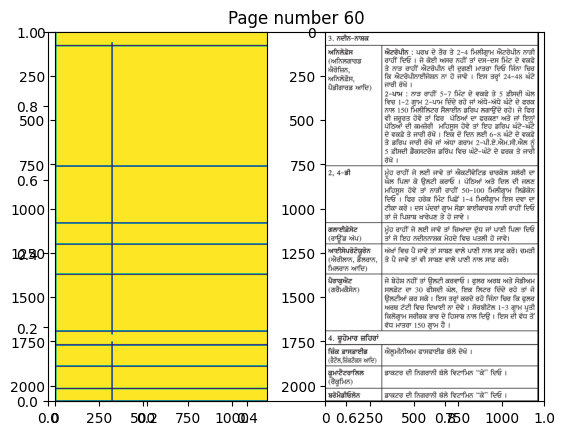

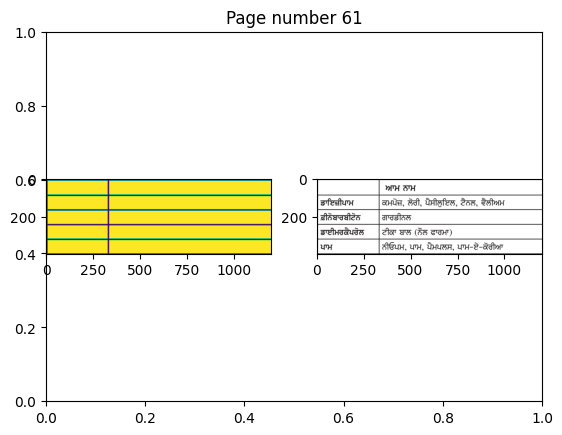

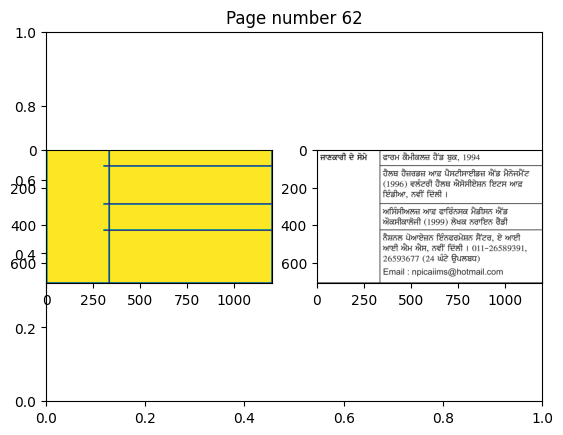

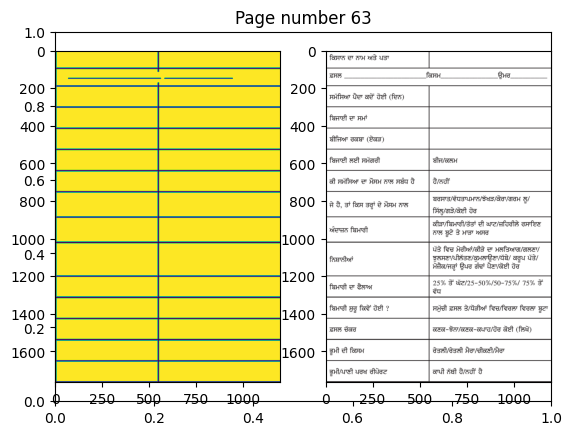

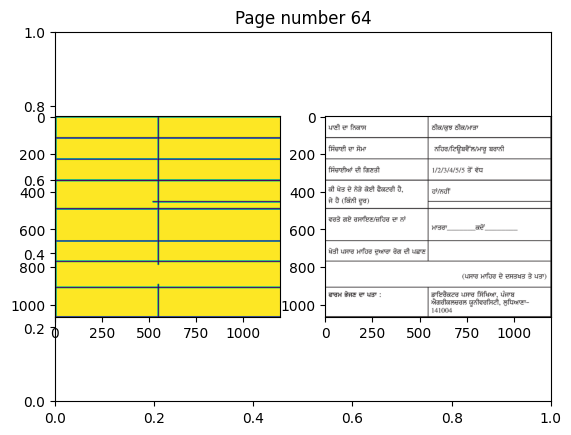

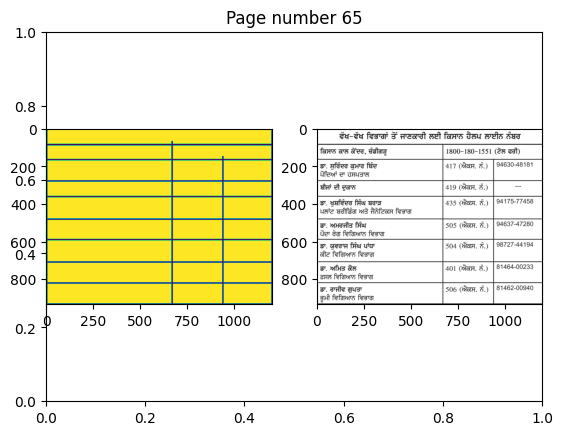

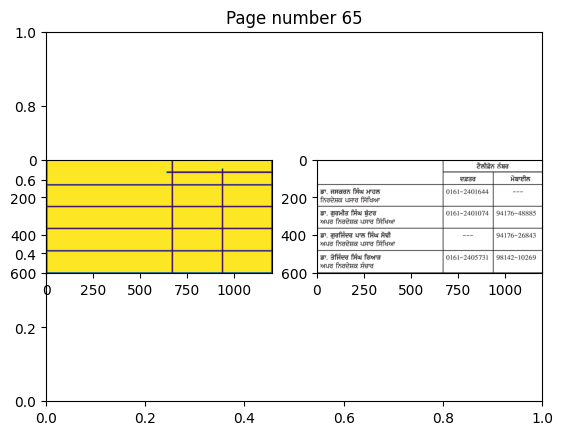

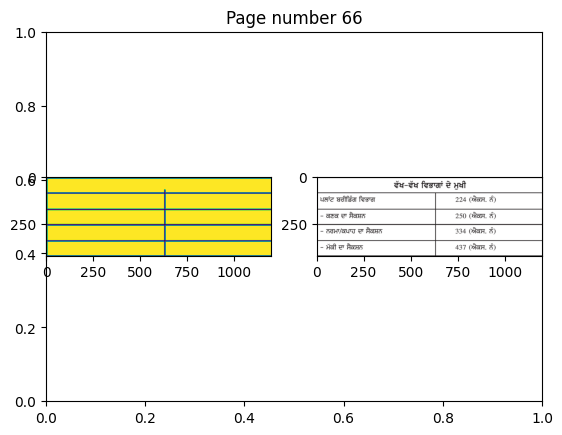

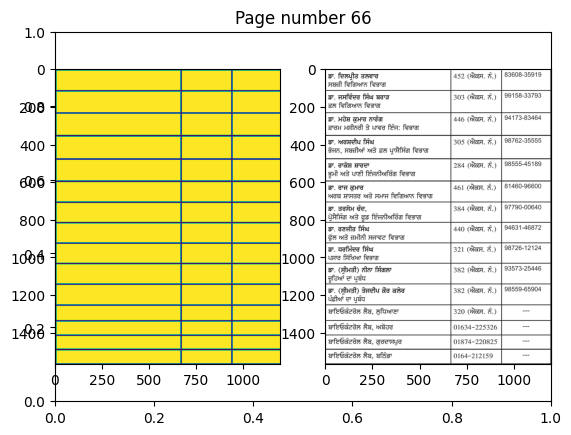

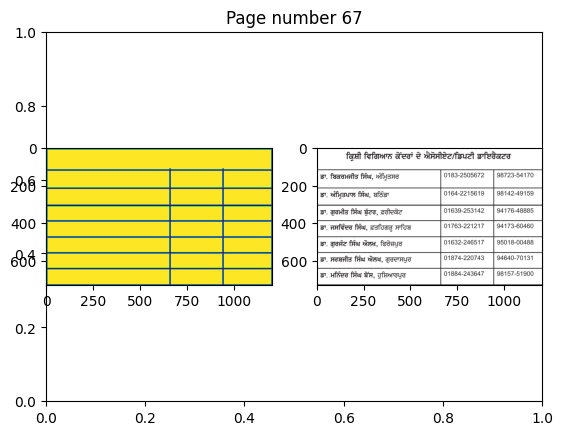

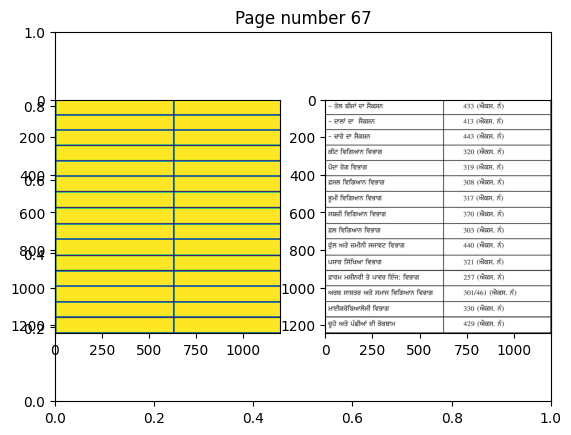

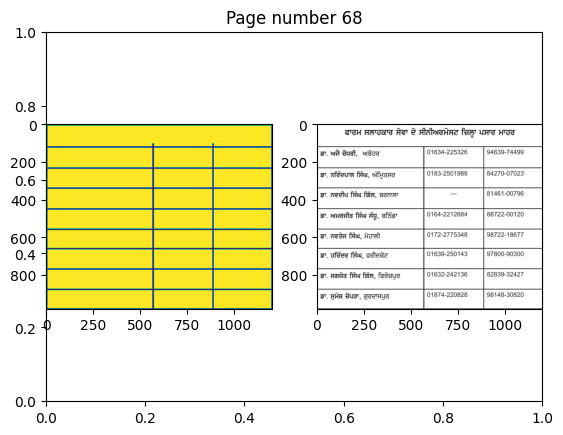

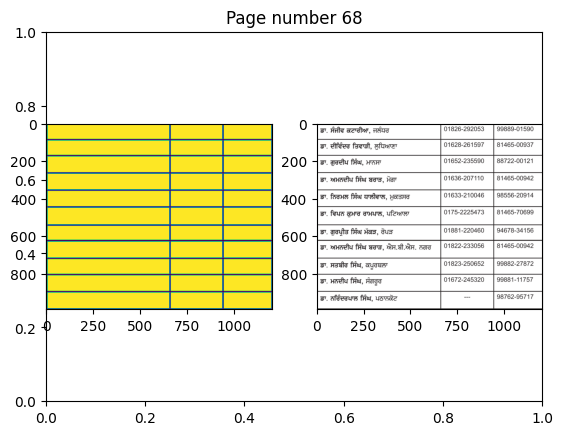

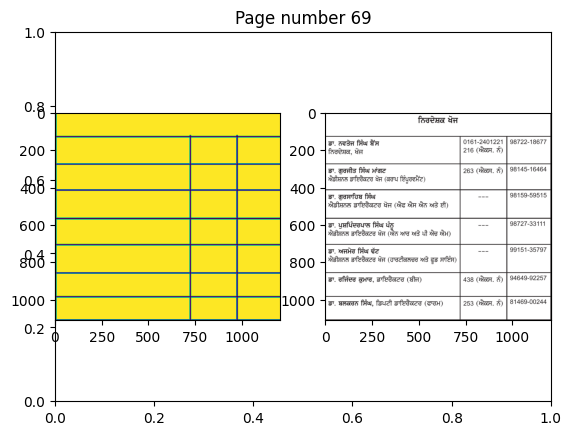

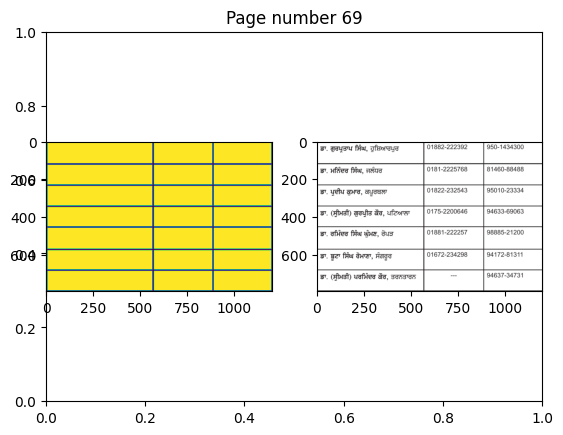

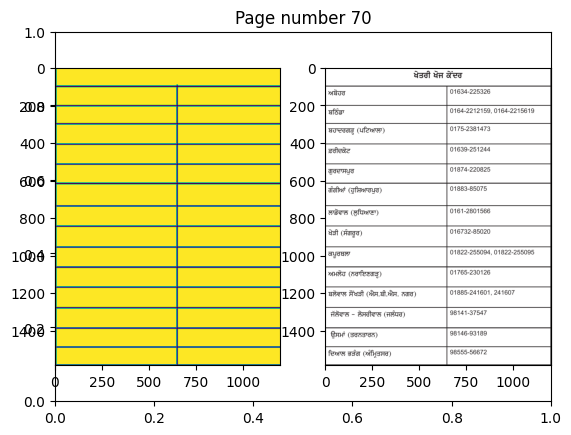

In [36]:
for idx,page in enumerate(tables):
    for table in page:
        if idx not in defected_pages:
            plt.title(f'Page number {idx}')
            plt.subplot(121)
            plt.imshow(get_cells_coordinates(table,v_erode=10,v_dilate=15,h_erode=36,h_dilate=45))
    
            plt.subplot(122)
            plt.imshow(table)
    
            plt.show()
        else:
            plt.title(f'Page number {idx}')
            plt.subplot(121)
            plt.imshow(get_cells_coordinates(table,6,20,35,50))
    
            plt.subplot(122)
            plt.imshow(table)
    
            plt.show()
            

In [37]:
# 1,2,3,4,7,8,11,34
all_text = ''
for idx,table in enumerate(tables):
    if idx not in defected_pages:
        all_text = all_text + f'page-{idx}\n'
    #     print(len(table))
        for curr in table:
            try:
                bounding_boxes = get_cells_coordinates_include_verification(curr,v_erode=10,v_dilate=15,h_erode=36,h_dilate=45)
                ocr = get_text_csv(bounding_boxes,curr)
                all_text = all_text + ocr + '\n'
                # print(ocr)
            except:
                continue
        all_text = all_text + '\n\n\n\n'
    else:
        all_text = all_text + f'page-{idx}\n'
#     print(len(table))
        for curr in table:
            try:
                bounding_boxes = get_cells_coordinates_include_verification(curr,6,25,35,50)
                ocr = get_text_csv(bounding_boxes,curr)
                all_text = all_text + ocr + '\n'
                print(ocr)
            except:
                continue
        all_text = all_text + '\n\n\n\n'

(281, 126) (1205, 1407)
(368, 113) (1206, 1248)
(368, 443) (1206, 2115)
(586, 67) (1199, 1923)
(586, 334) (1199, 995)
(132, 228) (1205, 1945)
(533, 93) (1199, 467)
(579, 67) (1199, 548)
(243, 109) (1199, 967)
(579, 406) (1199, 1793)
(579, 1056) (1199, 1066)
(591, 120) (1199, 642)
(371, 114) (1199, 1864)
(371, 2096) (1199, 2106)
(451, 68) (1199, 1943)
(451, 921) (1199, 931)
(591, 1) (1203, 226)
,,,
,ਪਨੀਰੀ ਬੀਜਣ ਦਾ ਸਮਾਂ,ਪਨੀਰੀ ਲਾਉਣ ਦਾ ਸਮਾਂ,
,ਉ) ਨਵੰਬਰ ਦਾ ਤੀਜਾ ਹਫ਼ਤਾ,ਅਧ ਫ਼ਰਵਰੀ,
,ਅ) ਫ਼ਰਵਰੀ ਦਾ ਪਹਿਲਾ ਹਫ਼ਤਾ,ਅਖ਼ੀਰ ਅਪ੍ਰੈਲ,

(591, 1) (1200, 311)
,,,
,ਮਹੀਨਾ,ਪਾਣੀ ਦੇਣ ਦਾ ਸਮਾਂ (ਮਿੰਟਾਂ ਵਿੱਚ),
,ਮਾਰਚ,ਚ],
,ਅਪ੍ਰੈਲ,61,
,ਮਈ,137,

(591, 1) (1200, 234)
,,,
,ਜੂਨ,110,
,ਜੁਲਾਈ,60,
,ਅਗਸਤ,60,

(751, 67) (1199, 498)
(753, 128) (1199, 1123)
(751, 436) (1199, 1253)
(381, 113) (1199, 1835)
(381, 962) (1199, 2090)
(381, 840) (1199, 1698)
(294, 63) (1201, 1057)
(854, 1) (1200, 371)
,,,
,ਕੀੜੇ,ਰੋਕਥਾਮ,
,1. ਤੇਲਾ/ਚੇਪਾ,,
,2. ਫ਼ਲੀ ਵਿੱਚ ਮੋਰੀਆਂਕਰਨ ਵਾਲੀ ਸੁੰਡੀ ਜਾਂਨੀਲੀ ਤਿੱਤਲੀ,,

(418, 63) (1199, 1199)
(591, 79) (1199, 451)
(607, 67) (1

In [38]:
print(all_text)

page-0
ਸਬਜ਼ੀ,ਰਕਬਾ(ਹਜ਼ਾਰ ਹੈਕਟੇਅਰ),ਔਸਤ ਝਾੜ(ਕੁਇੰਟਲ/ਹੈਕਟੇਅਰ),ਪੈਦਾਵਾਰ(ਹਜ਼ਾਰ ਟਨ),
ਆਲੂ,107.09,275.34,2948.55,
ਮਟਰ,43.89,106.41,467.01,
ਜੜ੍ਹਾਂ ਵਾਲੀਆਂਸਬਜ਼ੀਆਂ,28.07,249.27,699.61,
ਵੇਲਾਂ ਵਾਲੀਆਂਸਬਜ਼ੀਆਂ,18.01,195.09,351.27,
ਫੁੱਲ ਗੋਭੀ,22.98,196.12,450.60,
ਪਿਆਜ਼,10.35,238.27,246.52,
ਟਮਾਟਰ,10.28,259.74,266.91,
ਮਿਰਚ,8.78,20.09,17.63,
ਲਸਣ,8.87,109.10,96.77,
ਬੰਦ ਗੋਭੀ,7.98,161.68,129.01,
ਖਰਬੂਜ਼ਾ,7.01,194.87,136.62,
ਬੈਂਗਣ,5.47,225.72,139.79,
ਭਿੰਡੀ,5.31,103.44,54.88,
ਤਰਬੂਜ਼,2.19,180.84,38.30,
ਹੋਰ ਸਬਜ਼ੀਆਂ,19.22,34.39,66.09,
,305.5,,6109.56,





page-1
ਕੀੜੇ ਅਤੇ ਹਮਲੇ ਦੀਆਂਨਿਸ਼ਾਨੀਆਂ,ਰੋਕਥਾਮ,ਸਾਵਧਾਨੀਆਂ,
1. ਲਾਲ ਭੂੰਡੀ : ਜਦੋਂਪੌਦੇ ਉੱਗਣ ਪਿੱਛੋਂ ਛੋਟੇਹੀ ਰੱਦ ਰਨ ਤਾ ਲਾਲਹਮਲਾਹਮਲਾ ਹੋਣ ਤੇ ਫ਼ਸਲਬਿਲਕੁਲ ਤਬਾਹ ਹੋਜਾਂਦੀ ਹੈ।,ਨਵੇਂ ਜੰਮੇ ਬੂਟਿਆਂ ਦੇ ਪੱਤਿਆਂਉੱਪਰ ਗੋਹੇ ਦੀ ਸਵਾਹ ਦਾ 3-4ਵਾਰ ਹਫਤੇ ਦੇ ਵਕਫੇ ਤੇ ਧੂੜਾਦਿਓ।,ਇਸ ਕੀੜੇ ਦੇ ਹਮਲੇ ਤੋਂਬਚਣ ਲਈ ਫ਼ਸਲ ਨਵੰਬਰਵਿੱਚ ਹੀ ਬੀਜੋ ।,
2. ਚੇਪਾ : ਇਸ ਦਾਹਮਲਾ ਫ਼ਰਵਰੀ ਤੋਂਮਾਰਚ ਤੱਕ ਹੁੰਦਾ ਹੈ।ਇਹ ਪੱਤਿਆਂ ਤੋਂ ਰਸਜੂਸ ਲੈਂਦਾ ਹੈ । ਤੇਲਾਕਈ ਵਿਸ਼ਾਣੂੰ ਰੋਗ ਵੀਫੈਲਾਉਂਦਾ ਹੈ।,,,
3. ਚਿੱਟੀ ਮੌਖੀ : ਇਸਦੇਬਾਲਗ ਅਤੇ ਬੱਚੇ ਪੌਤਿਆਂਦਾ ਰਸ ਚੂਸਦੇ ਹਨ ਅਤੇਝਾੜ ਘਟਾਉਦੇ ਹ

In [327]:
defected_pages=[15,16,17,24,28,36,48,53,55,61]
defected_tables=[]
for i in defected_pages:
    defected_tables.append(tables[i])

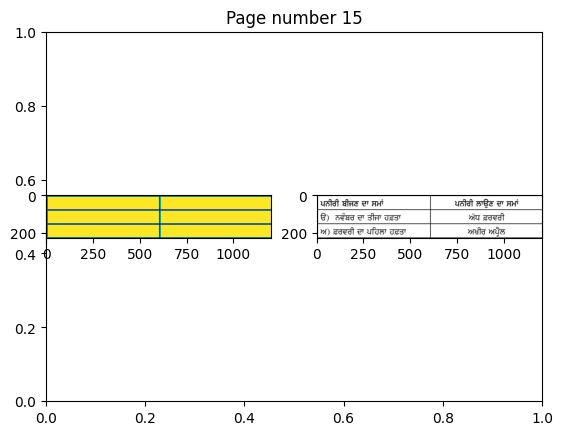

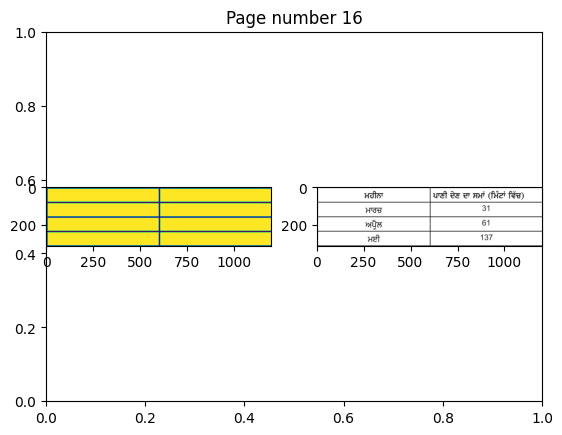

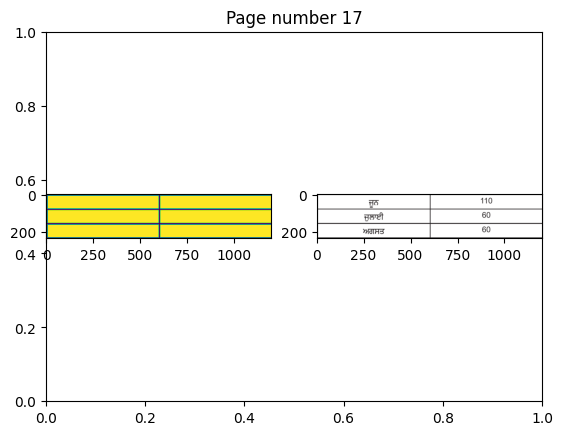

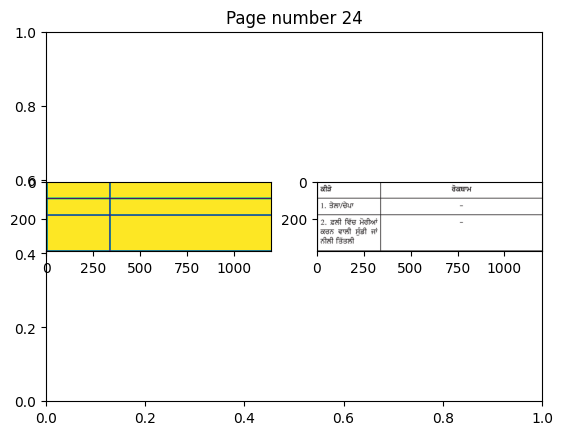

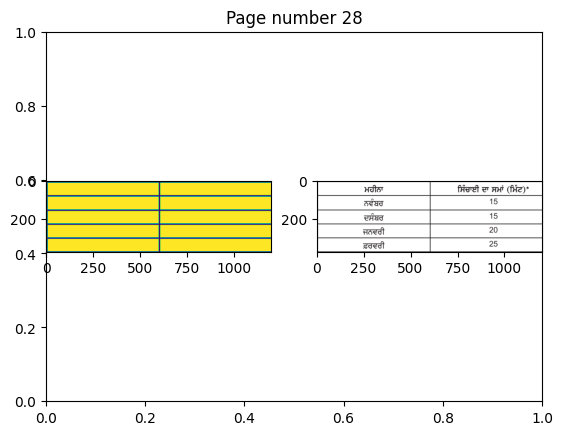

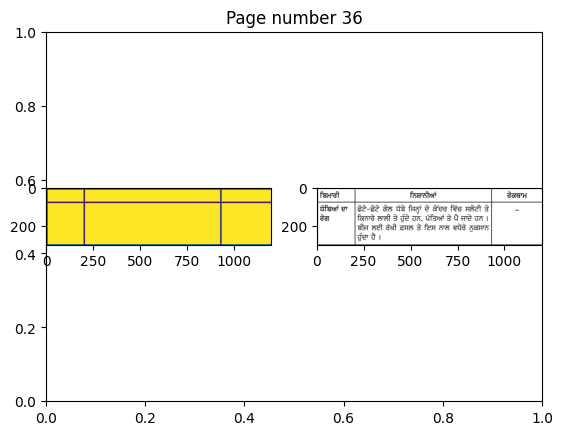

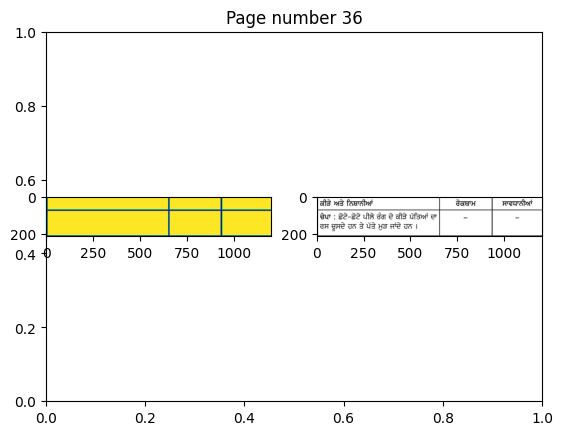

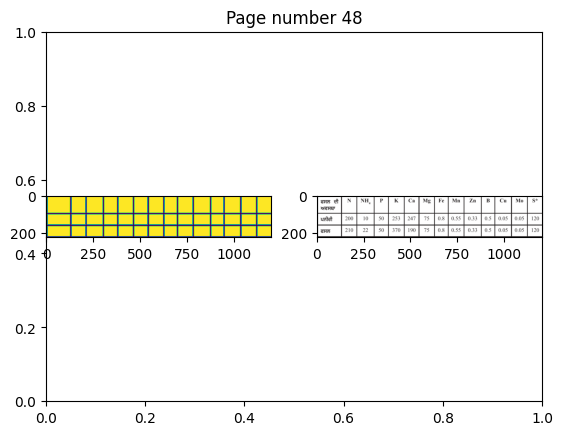

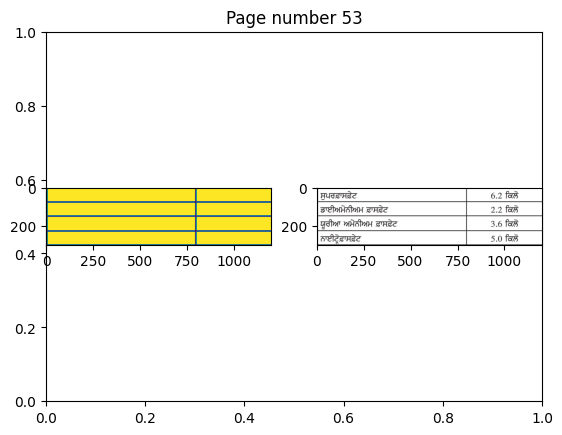

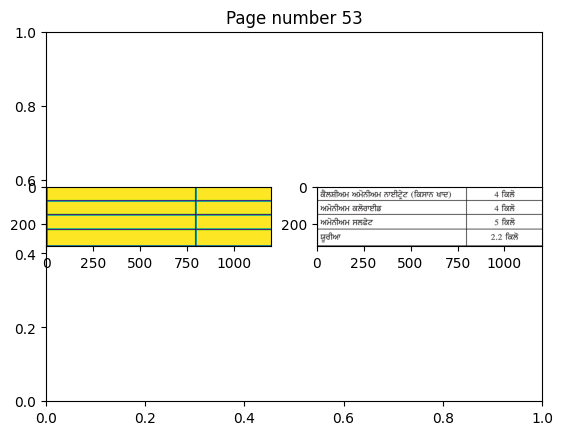

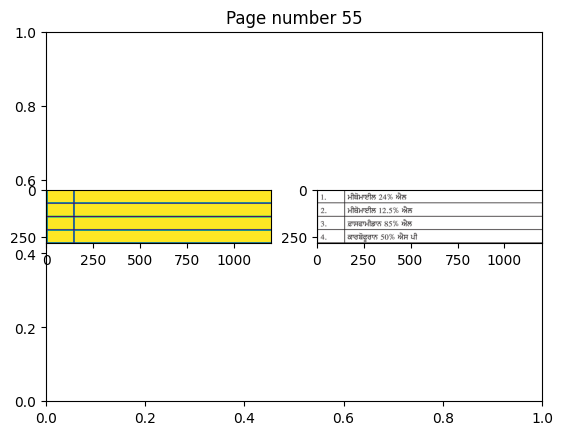

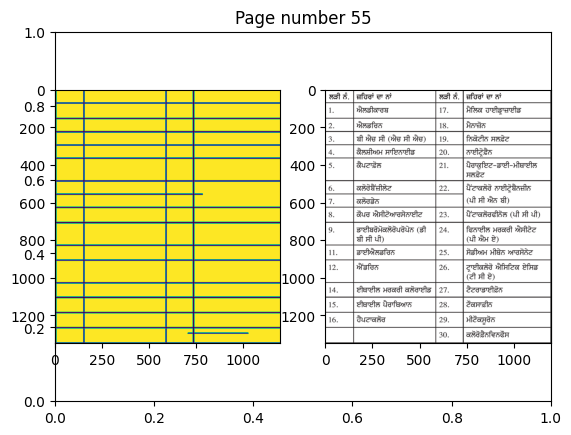

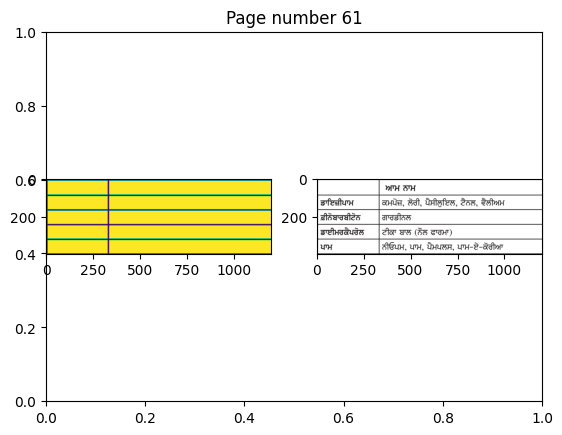

In [424]:
for idx,page in enumerate(defected_tables):
    for table in page:
        plt.title(f'Page number {defected_pages[idx]}')
        plt.subplot(121)
        plt.imshow(get_cells_coordinates(table))

        plt.subplot(122)
        plt.imshow(table)

        plt.show()

In [425]:
all_text = ''
for idx,table in enumerate(defected_tables):
    all_text = all_text + f'page-{defected_pages[idx]}\n'
#     print(len(table))
    for curr in table:
        try:
            bounding_boxes = get_cells_coordinates_include_verification(curr)
            ocr = get_text_csv(bounding_boxes,curr)
            all_text = all_text + ocr + '\n'
            print(ocr)
        except:
            continue
    all_text = all_text + '\n\n\n\n'
# 55,61

(591, 1) (1203, 226)
,,,
,ਪਨੀਰੀ ਬੀਜਣ ਦਾ ਸਮਾਂ,ਪਨੀਰੀ ਲਾਉਣ ਦਾ ਸਮਾਂ,
,ਉ) ਨਵੰਬਰ ਦਾ ਤੀਜਾ ਹਫ਼ਤਾ,ਅੱਧ ਫ਼ਰਵਰੀ,
,ਅ) ਫ਼ਰਵਰੀ ਦਾ ਪਹਿਲਾ ਹਫ਼ਤਾ,ਅਖ਼ੀਰ ਅਪ੍ੈਲ,

(591, 1) (1200, 311)
,,,
,ਮਹੀਨਾ,ਪਾਣੀ ਦੇਣ ਦਾ ਸਮਾਂ (ਮਿੰਟਾਂ ਵਿੱਚ),
,ਮਾਰਚ,31,
,ਅਪ੍ਰੈਲ,61,
,ਮਈ,137,

(591, 1) (1200, 234)
,,,
,ਜੂਨ,110,
,ਜੁਲਾਈ,60,
,ਅਗਸਤ,60,

(854, 1) (1200, 371)
,,,
,ਕੀੜੇ,ਰੋਕਥਾਮ,
,1. ਤੇਲਾ/ਚੇਪਾ,,
,2. ਫ਼ਲੀ ਵਿੱਚ ਮੋਰੀਆਂਕਰਨ ਵਾਲੀ ਸੁੰਡੀ ਜਾਂਨੀਲੀ ਤਿੱਤਲੀ,,

(591, 1) (1200, 377)
,,,
,ਮਹੀਨਾ,ਸਿੰਚਾਈ ਦਾ ਸਮਾਂ (ਮਿੰਟ)",
,ਨਵੰਬਰ,15,
,ਦਸੰਬਰ,15,
,ਜਨਵਰੀ,20,
,ਫ਼ਰਵਰੀ,25,

(265, 1) (1200, 303)
,,,,
,ਬਿਮਾਰੀ,ਨਿਸ਼ਾਨੀਆਂ,ਰੋਕਥਾਮ,
,ਧੌਬਿਆਂ ਦਾਰੋਗ,ਛੋਟੇ-ਛੋਟੇ ਗੋਲ ਧੱਬੇ ਜਿਨ੍ਹਾਂ ਦੇ ਕੇਂਦਰ ਵਿੱਚ ਸਲੇਟੀ ਤੇਕਿਨਾਰੇ ਲਾਲੀ ਤੇ ਹੁੰਦੇ ਹਨ, ਪੌਤਿਆਂ ਤੇ ਪੈ ਜਾਦੇ ਹਨ ।ਬੀਜ ਲਈ ਰੱਖੀ ਫ਼ਸਲ ਤੇ ਇਸ ਨਾਲ ਵਧੇਰੇ ਨੁਕਸਾਨਹੁੰਦਾ ਹੈ ।,,

(262, 1) (1202, 212)
,,,,
,ਕੀੜੇ ਅਤੇ ਨਿਸ਼ਾਨੀਆਂ,ਰੋਕਥਾਮ,ਸਾਵਧਾਨੀਆਂ,
,ਚੇਪਾ : ਛੋਟੇ-ਛੋਟੇ ਪੀਲੇ ਰੰਗ ਦੇ ਕੀੜੇ ਪੌਤਿਆਂ ਦਾਰਸ ਚੂਸਦੇ ਹਨ ਤੇ ਪੌਤੇ ਮੁੜ ਜਾਂਦੇ ਹਨ ।,,,

(75, 1) (1202, 223)
,,,,,,,,,,,,,,,
,ਫਸਲ ਦੀਅਵਸਥਾ,N,NH,,P,K,Ca,Mg,Fe,Mn,Zn,B,Cu,Mo,6,
,ਪਨੀਰੀ,200,10,50,253,247,75,0.8,0.55,0.33,0.5,0.0

In [10]:
print(all_text)

page-0
ਸਬਜ਼ੀ,ਰਕਬਾ(ਹਜ਼ਾਰ ਹੈਕਟੇਅਰ),ਔਸਤ ਝਾੜ(ਕੁਇੰਟਲ/ਹੈਕਟੇਅਰ),ਪੈਦਾਵਾਰ(ਹਜ਼ਾਰ ਟਨ),
ਆਲੂ,107.09,275.34,2948.55,
ਮਟਰ,43.89,106.41,467.01,
ਜੜ੍ਹਾਂ ਵਾਲੀਆਂਸਬਜ਼ੀਆਂ,28.07,249.27,699.61,
ਵੇਲਾਂ ਵਾਲੀਆਂਸਬਜ਼ੀਆਂ,18.01,195.09,351.27,
ਫੁੱਲ ਗੋਭੀ,22.98,196.12,450.60,
ਪਿਆਜ਼,10.35,238.27,246.52,
ਟਮਾਟਰ,10.28,259.74,266.91,
ਮਿਰਚ,8.78,20.09,17.63,
ਲਸਣ,8.87,109.10,96.77,
ਬੰਦ ਗੋਭੀ,7.98,161.68,129.01,
ਖਰਬੂਜ਼ਾ,7.01,194.87,136.62,
ਬੈਂਗਣ,5.47,225.72,139.79,
ਭਿੰਡੀ,5.31,103.44,54.88,
ਤਰਬੂਜ਼,2.19,180.84,38.30,
ਹੋਰ ਸਬਜ਼ੀਆਂ,19.22,34.39,66.09,
,305.5,,6109.56,





page-1
ਕੀੜੇ ਅਤੇ ਹਮਲੇ ਦੀਆਂਨਿਸ਼ਾਨੀਆਂ,ਰੋਕਥਾਮ,ਸਾਵਧਾਨੀਆਂ,
1. ਲਾਲ ਭੂੰਡੀ : ਜਦੋਂਪੌਦੇ ਉੱਗਣ ਪਿੱਛੋਂ ਛੋਟੇਹੀ ਰੱਦ ਰਨ ਤਾ ਲਾਲਹਮਲਾਹਮਲਾ ਹੋਣ ਤੇ ਫ਼ਸਲਬਿਲਕੁਲ ਤਬਾਹ ਹੋਜਾਂਦੀ ਹੈ।,ਨਵੇਂ ਜੰਮੇ ਬੂਟਿਆਂ ਦੇ ਪੱਤਿਆਂਉੱਪਰ ਗੋਹੇ ਦੀ ਸਵਾਹ ਦਾ 3-4ਵਾਰ ਹਫਤੇ ਦੇ ਵਕਫੇ ਤੇ ਧੂੜਾਦਿਓ।,ਇਸ ਕੀੜੇ ਦੇ ਹਮਲੇ ਤੋਂਬਚਣ ਲਈ ਫ਼ਸਲ ਨਵੰਬਰਵਿੱਚ ਹੀ ਬੀਜੋ ।,
2. ਚੇਪਾ : ਇਸ ਦਾਹਮਲਾ ਫ਼ਰਵਰੀ ਤੋਂਮਾਰਚ ਤੱਕ ਹੁੰਦਾ ਹੈ।ਇਹ ਪੱਤਿਆਂ ਤੋਂ ਰਸਜੂਸ ਲੈਂਦਾ ਹੈ । ਤੇਲਾਕਈ ਵਿਸ਼ਾਣੂੰ ਰੋਗ ਵੀਫੈਲਾਉਂਦਾ ਹੈ।,,,
3. ਚਿੱਟੀ ਮੌਖੀ : ਇਸਦੇਬਾਲਗ ਅਤੇ ਬੱਚੇ ਪੌਤਿਆਂਦਾ ਰਸ ਚੂਸਦੇ ਹਨ ਅਤੇਝਾੜ ਘਟਾਉਦੇ ਹ

In [39]:
output_file = 'data_books/ocr_punjabi/pp_vegs_tables.txt'
f=open(output_file,'w')
f.write(all_text)
f.close()

In [402]:
image = tables[55][1]
# image = cv2.imread(image)
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh1,img = cv2.threshold(img,128,255,cv2.THRESH_OTSU)
img = cv2.bitwise_not(img)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, img.shape[1]//150))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//150, 1))

In [411]:
vertical_lines = cv2.erode(img, vertical_kernel, iterations=6)
vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=25)

In [412]:
horizontal_lines = cv2.erode(img, hor_kernel, iterations=50)
horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=50)

In [413]:
vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)

In [414]:
thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255,cv2.THRESH_OTSU)
b_image = cv2.bitwise_not(cv2.bitwise_xor(img,vertical_horizontal_lines))


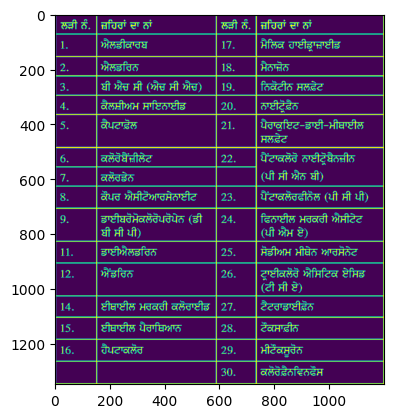

In [415]:
plt.imshow(img)

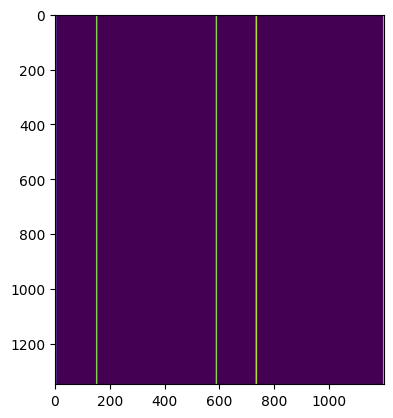

In [416]:
plt.imshow(vertical_lines)

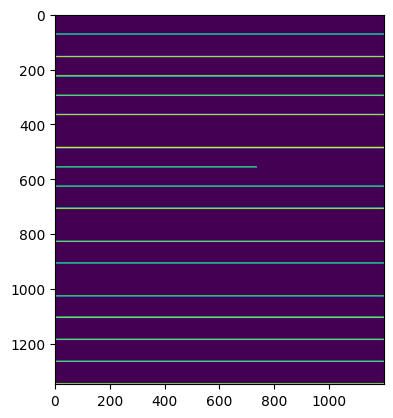

In [417]:
plt.imshow(horizontal_lines)

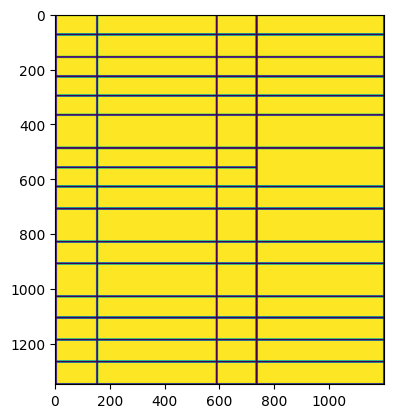

In [418]:
plt.imshow(vertical_horizontal_lines)

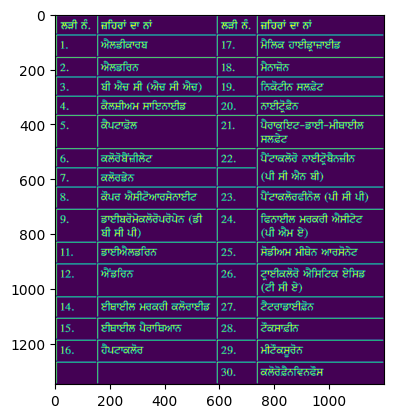

In [419]:
plt.imshow(b_image)